Cluster listings to define category of the listings, and segment hosts to define segmentation of the hosts.

In [59]:
#%pip install -q textblob vaderSentiment scikit-learn-extra

In [60]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from datetime import datetime

In [61]:
import warnings
warnings.filterwarnings("ignore")

<h2>Import & Clean Data

(building off of what alex has already done)

In [62]:

base_path = Path("C:/Users/frank/Documents/Classes/Data Mining Methodologies II/Final/airbnb-price-analysis-main/")
#file_path = base_path / "file.txt"

# Define file paths (update these paths based on your local directory)
file_paths = {
    "listings": base_path / "data/listings.csv.gz",
    "calendar": base_path / "data/calendar.csv.gz",
    "reviews": base_path / "data/reviews.csv.gz",
    "listings_summary": base_path / "data/listings.csv",
    "reviews_summary": base_path / "data/reviews.csv",
    "neighbourhoods": base_path / "data/neighbourhoods.csv",
    "neighbourhoods_geojson": base_path / "data/neighbourhoods.geojson"
}

# Load files into individual dataframes
listings = pd.read_csv(file_paths["listings"], low_memory=False)
calendar = pd.read_csv(file_paths["calendar"], low_memory=False)
reviews = pd.read_csv(file_paths["reviews"], low_memory=False)
listings_summary = pd.read_csv(file_paths["listings_summary"], low_memory=False)
reviews_summary = pd.read_csv(file_paths["reviews_summary"], low_memory=False)
neighbourhoods = pd.read_csv(file_paths["neighbourhoods"], low_memory=False)
neighbourhoods_geojson = gpd.read_file(file_paths["neighbourhoods_geojson"])

# Display summary and head of each dataframe
dataframes = {
    "listings": listings,
    "calendar": calendar,
    "reviews": reviews,
    "listings_summary": listings_summary,
    "reviews_summary": reviews_summary,
    "neighbourhoods": neighbourhoods,
    "neighbourhoods_geojson": neighbourhoods_geojson
}

In [63]:
# Remove unnecessary columns
columns_to_remove = [
    "listing_url", "scrape_id", "last_scraped", "source", "description",
    "neighborhood_overview", "picture_url", "host_url", "host_about",
    "host_thumbnail_url", "host_picture_url", "host_neighbourhood",
    "neighbourhood", "neighbourhood_group_cleansed", "bathrooms", 
    "bedrooms", "amenities", "calendar_updated", "calendar_last_scraped",
    "license", "instant_bookable", "host_verifications", "name", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights",
    "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"
]

listings_cleaned = listings.drop(columns=columns_to_remove)

# Clean the price column by removing dollar signs and converting to numeric
listings_cleaned['price'] = listings_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)

# Extract numeric values from bathrooms_text and create a new bathrooms column
listings_cleaned['bathrooms'] = listings_cleaned['bathrooms_text'].str.extract('(\d+(\.\d+)?)')[0].astype(float)

# Drop the old bathrooms_text column
listings_cleaned.drop(columns=['bathrooms_text'], inplace=True)

# Calculate vacancy and booking rates
listings_cleaned['vacancy_rate_30'] = listings_cleaned['availability_30'] / 30
listings_cleaned['vacancy_rate_60'] = listings_cleaned['availability_60'] / 60
listings_cleaned['vacancy_rate_90'] = listings_cleaned['availability_90'] / 90
listings_cleaned['vacancy_rate_365'] = listings_cleaned['availability_365'] / 365




In [64]:
listings_cleaned['bathrooms'].fillna(listings_cleaned['bathrooms'].mean(), inplace=True)
listings_cleaned['beds'].fillna(listings_cleaned['beds'].mean(), inplace=True)
listings_cleaned['price'].fillna(listings_cleaned['price'].mean(), inplace=True)
listings_cleaned['availability_30'].fillna(listings_cleaned['availability_30'].mean(), inplace=True)
listings_cleaned['availability_60'].fillna(listings_cleaned['availability_60'].mean(), inplace=True)
listings_cleaned['availability_90'].fillna(listings_cleaned['availability_90'].mean(), inplace=True)
listings_cleaned['availability_365'].fillna(listings_cleaned['availability_365'].mean(), inplace=True)
listings_cleaned['review_scores_rating'].fillna(listings_cleaned['review_scores_rating'].mean(), inplace=True)
listings_cleaned['reviews_per_month'].fillna(listings_cleaned['reviews_per_month'].mean(), inplace=True)

listings_cleaned['review_scores_accuracy'].fillna(listings_cleaned['review_scores_accuracy'].mean(), inplace=True)
listings_cleaned['review_scores_checkin'].fillna(listings_cleaned['review_scores_checkin'].mean(), inplace=True)
listings_cleaned['review_scores_communication'].fillna(listings_cleaned['review_scores_communication'].mean(), inplace=True)
listings_cleaned['review_scores_cleanliness'].fillna(listings_cleaned['review_scores_cleanliness'].mean(), inplace=True)
listings_cleaned['review_scores_location'].fillna(listings_cleaned['review_scores_location'].mean(), inplace=True)
listings_cleaned['review_scores_value'].fillna(listings_cleaned['review_scores_value'].mean(), inplace=True)

In [65]:
# Display the first 5 rows of the cleaned dataframe
listings_cleaned.head()

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
0,57818,275948,Von Inc,2010-11-01,"Hollywood, FL",within an hour,100%,96%,t,3.0,...,5.00,4.97,4.88,4.71,0.43,1.0,0.066667,0.033333,0.111111,0.586301
1,69824,351303,Tracy,2011-01-17,"Silver Spring, MD",within an hour,100%,50%,f,3.0,...,4.75,4.75,5.00,4.50,0.12,2.0,0.633333,0.316667,0.211111,0.769863
2,83449,454736,"Jon, Mary Pop Apartments",2011-03-21,"Dania Beach, FL",within an hour,100%,97%,f,17.0,...,4.94,4.90,4.81,4.87,0.21,1.0,0.000000,0.016667,0.011111,0.002740
3,105411,532930,Sonia,2011-04-25,"Southwest Ranches, FL",within an hour,80%,57%,f,3.0,...,5.00,5.00,4.25,5.00,0.03,2.0,0.800000,0.900000,0.933333,0.983562
4,129099,637272,Bianca,2011-05-28,"Buenos Aires, Argentina",a few days or more,36%,18%,f,9.0,...,4.44,4.32,4.54,4.08,0.18,1.5,0.200000,0.300000,0.322222,0.832877


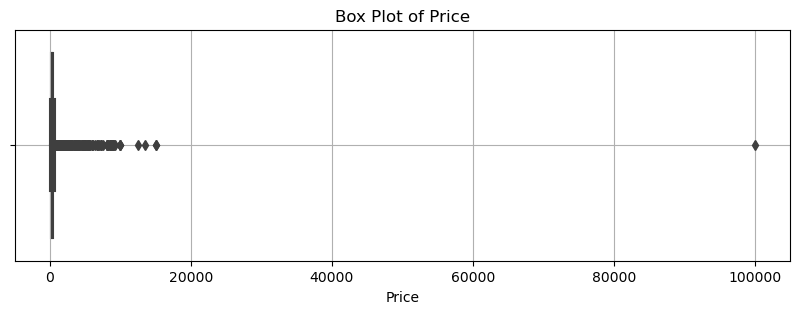

In [66]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=listings_cleaned['price'])
plt.xlabel('Price')
plt.title('Box Plot of Price')
plt.grid(True)
plt.show()

In [67]:
listings_cleaned[listings_cleaned['price'] > 10000]

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
4706,46698806,10552268,Cristina,2013-12-10,"Mooresville, NC",within an hour,94%,72%,t,6.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,4.5,0.933333,0.966667,0.977778,0.994521
7391,53810192,430653443,Reginald,2021-11-06,"Miramar, FL",within a day,89%,0%,f,1.0,...,4.64000,4.790000,4.790000,4.790000,0.620000,2.0,1.000000,1.000000,1.000000,1.000000
7752,539000625832293175,408615863,Max,2021-06-22,NaN,within a day,90%,81%,t,22.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,3.0,1.000000,1.000000,1.000000,0.997260
10753,727521786498618311,268830423,Janit,2019-06-15,"Bear Creek, WI",within a day,100%,0%,f,3.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,1.0,1.000000,1.000000,1.000000,1.000000
12210,806381631034673979,31852158,Jay,2015-04-24,NaN,within an hour,100%,97%,f,7.0,...,5.00000,5.000000,5.000000,5.000000,0.190000,10.0,1.000000,1.000000,1.000000,0.997260


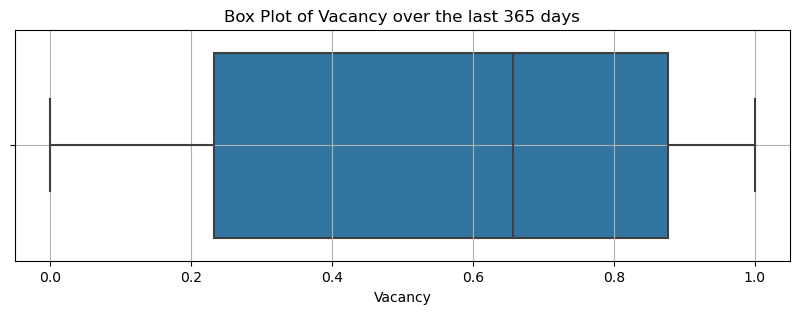

In [68]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=listings_cleaned['vacancy_rate_365'])
plt.xlabel('Vacancy')
plt.title('Box Plot of Vacancy over the last 365 days')
plt.grid(True)
plt.show()

Looking for outliers in the price, there's a better way to filter the dataframe and eliminate the price outlier if we just remove all listings that have ~100% vacancy 

In [69]:
listings_cleaned.shape

(18230, 46)

In [70]:
listings_cleaned = listings_cleaned[listings_cleaned['vacancy_rate_365'] <= .999]

In [71]:
listings_cleaned.shape

(17795, 46)

In [72]:
18230-17795

435

Eliminated 435 outliers who have been completely or almost completely vacant for a year

<h1>Clustering listings

To cluster listings, we'll first create a seperate dataframe with only the information on the listings. We're going to include the listing ID, all the relevant numerical information on the listing itself, as well as the property & room type which we'll one-hot-encode.

In [73]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [74]:
#id column
id_features = ['id']

#numerical columns
num_features = ['price', 'latitude', 'longitude', 'vacancy_rate_365', 
              'accommodates', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365',
             'number_of_reviews','number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 
              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
              'review_scores_location', 'review_scores_value', 'reviews_per_month', 'bathrooms']

#categorical columns
cat_features = ['room_type']

In [75]:
listings_cleaned['property_type'].unique()

array(['Entire home', 'Entire rental unit', 'Entire condo',
       'Private room in guest suite', 'Private room in guesthouse',
       'Private room in condo', 'Entire townhouse', 'Entire guest suite',
       'Private room in rental unit', 'Private room in home',
       'Private room in bed and breakfast', 'Entire villa',
       'Private room in townhouse', 'Entire cottage',
       'Entire serviced apartment', 'Entire cabin',
       'Room in boutique hotel', 'Private room in resort',
       'Room in bed and breakfast', 'Private room in villa',
       'Entire bungalow', 'Entire guesthouse', 'Entire chalet',
       'Private room', 'Entire place', 'Room in aparthotel',
       'Room in hotel', 'Private room in bungalow', 'Camper/RV', 'Barn',
       'Room in serviced apartment', 'Room in resort', 'Boat',
       'Casa particular', 'Private room in tiny home',
       'Private room in farm stay', 'Private room in loft', 'Entire loft',
       'Entire resort', 'Private room in casa particular', 

In [76]:
listings_cleaned['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

The number of categories in the property type column is unruly & seems unreliable. We will drop the column

We'll need to standardize the numerical columns and one-hot-encode the categorical columns

In [77]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('passthrough', 'passthrough', id_features)
    ])

transformed_data = preprocessor.fit_transform(listings_cleaned)

# Convert the transformed data back to a DataFrame
# Get feature names for one-hot encoded columns
encoded_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_columns = list(num_features) + list(encoded_columns) + id_features
transformed_df = pd.DataFrame(transformed_data, columns=all_columns)

<h2>PCA & Kmeans

In [78]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(transformed_df.drop(columns=id_features))

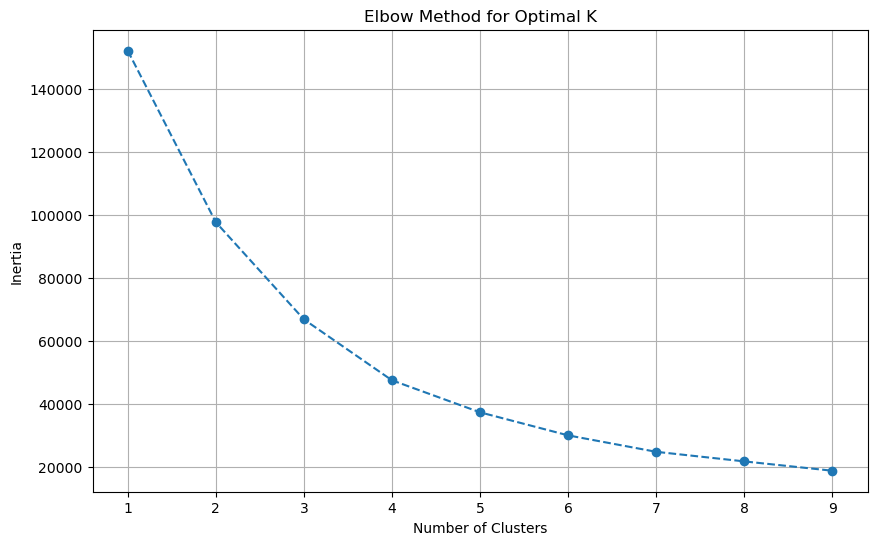

In [79]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

We will choose 4 clusters

In [80]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_data)
clusters = kmeans.labels_

transformed_df['cluster'] = clusters

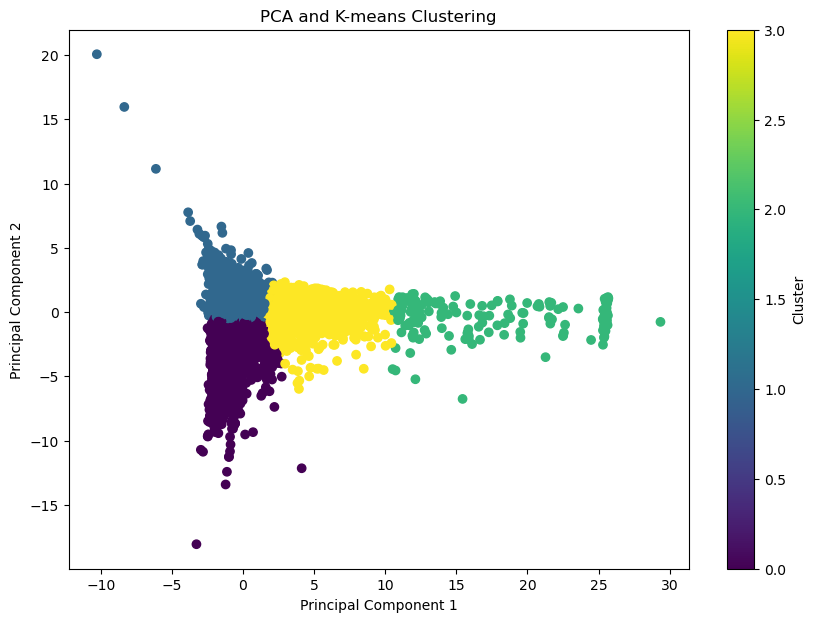

In [81]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA and K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [82]:
listings_cleaned_kmeans = listings_cleaned.copy()
listings_cleaned_kmeans['cluster'] = clusters

cluster_summary = listings_cleaned_kmeans.groupby('cluster').mean()

print("Cluster Summary Statistics (Mean):")
cluster_summary

Cluster Summary Statistics (Mean):


,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,price,minimum_nights,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
cluster,,,,,,,,,,,,,,,,,,,,,
0,5.304623e+17,2.236328e+08,133.537953,205.945123,26.108221,-80.139824,8.634635,5.230248,666.540148,4.404805,...,4.881148,4.882485,4.849731,4.754039,1.253443,2.704338,0.429423,0.483557,0.537159,0.665996
1,4.537893e+17,2.119422e+08,77.582585,112.026481,26.110783,-80.146055,3.650153,1.976395,203.602459,5.703644,...,4.864991,4.874647,4.837965,4.747155,1.605353,1.246895,0.364444,0.402761,0.445450,0.481184
2,5.978916e+17,2.487423e+08,115.024691,184.679012,26.078738,-80.156723,4.425926,2.454485,250.073900,3.450617,...,2.303519,2.188827,3.026111,1.913889,0.372722,1.462963,0.461728,0.506790,0.549931,0.506832
3,4.437497e+17,2.067604e+08,108.560160,175.083556,26.059825,-80.143812,4.509358,2.501057,256.404355,4.292112,...,4.339893,4.314479,4.467547,4.003282,0.709706,1.402857,0.487389,0.545354,0.595633,0.635609


<h1>PCA & K-Medoids

Calculating k-medoids at level 1
Calculating k-medoids at level 2
Calculating k-medoids at level 3
Calculating k-medoids at level 4
Calculating k-medoids at level 5
Calculating k-medoids at level 6
Calculating k-medoids at level 7
Calculating k-medoids at level 8
Calculating k-medoids at level 9


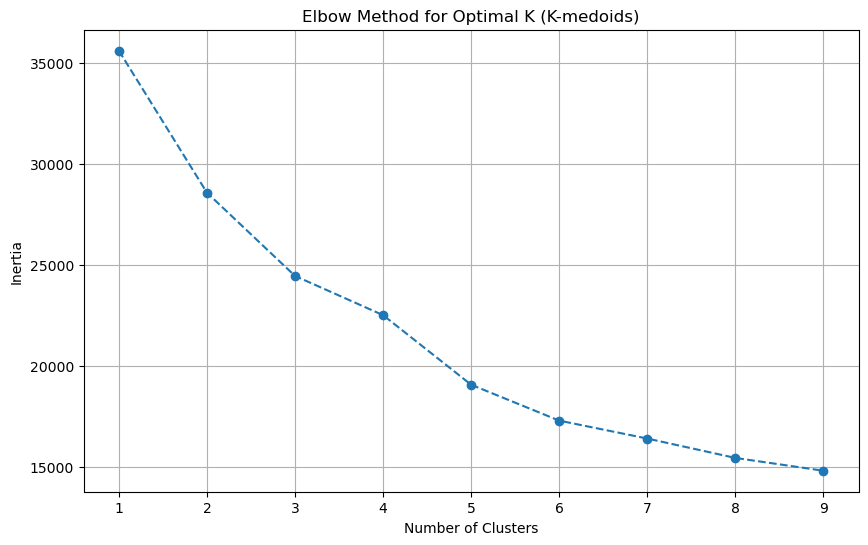

In [83]:
inertia = []
for k in range(1, 10):
    print('Calculating k-medoids at level ' + str(k)) #print progress because the process takes a while
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    kmedoids.fit(pca_data)
    inertia.append(kmedoids.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (K-medoids)')
plt.grid(True)
plt.show()

In [84]:
# Fit K-medoids clustering with the optimal number of clusters
optimal_k = 3
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
kmedoids.fit(pca_data)
clusters = kmedoids.labels_

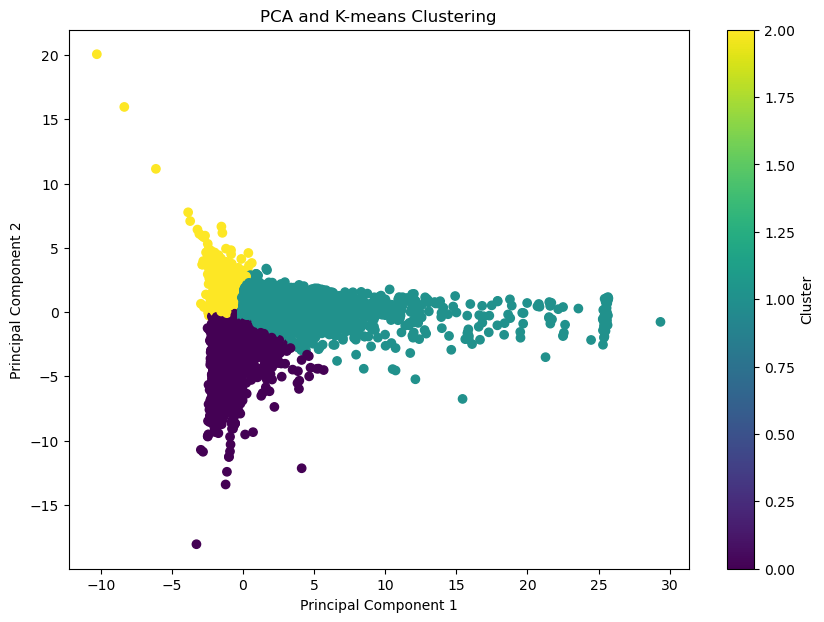

In [85]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA and K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [86]:
# Get indices of medoids in the original DataFrame
medoid_indices = kmedoids.medoid_indices_

# Print the indices of medoids
print("Indices of Medoids in the Original DataFrame:")
for cluster_id, index in enumerate(medoid_indices):
    print(f"Cluster {cluster_id}: Index {index}")

# Print the corresponding rows in the original DataFrame (optional)
print("\nCorresponding Rows in the Original DataFrame:")
listings_cleaned[num_features + cat_features].iloc[medoid_indices]

Indices of Medoids in the Original DataFrame:
Cluster 0: Index 6908
Cluster 1: Index 5513
Cluster 2: Index 5742

Corresponding Rows in the Original DataFrame:


,price,latitude,longitude,vacancy_rate_365,accommodates,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,room_type
7043,298.0,26.22884,-80.09838,0.561644,8,6.0,3,1125,205,33,...,4.73,4.85,4.76,4.94,4.82,4.91,4.73,1.30,2.0,Entire home/apt
5604,152.0,26.00278,-80.14533,0.473973,5,3.0,1,1125,173,58,...,4.62,4.67,4.53,4.88,4.88,4.59,4.48,1.94,1.0,Entire home/apt
5836,281.0,26.01593,-80.11543,0.252055,4,3.0,3,365,92,65,...,4.89,4.92,4.74,5.00,4.95,4.94,4.86,2.09,1.0,Entire home/apt


In [87]:
listings_cleaned_kmedoids = listings_cleaned.copy()
listings_cleaned_kmedoids['cluster'] = clusters

cluster_summary = listings_cleaned_kmedoids.groupby('cluster').mean()
cluster_summary2 = listings_cleaned_kmedoids.groupby('cluster').var()


print("Cluster Summary Statistics (Mean):")
cluster_summary.iloc[:,4:]

Cluster Summary Statistics (Mean):


,latitude,longitude,accommodates,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
cluster,,,,,,,,,,,,,,,,,,,,,
0,26.110975,-80.139314,8.365433,5.040302,632.230237,4.470630,537.344785,12.480954,28.067462,46.806693,...,4.887852,4.889091,4.853567,4.760968,1.260275,2.620862,0.416032,0.467791,0.520074,0.649051
1,26.086253,-80.146577,3.862660,2.090139,218.576859,6.388756,444.761109,13.027140,28.795705,47.019684,...,4.616232,4.618813,4.659635,4.413679,1.160376,1.270934,0.434238,0.479928,0.522441,0.542359
2,26.123431,-80.146350,3.356425,1.819119,183.577708,4.491501,459.053190,9.652349,21.434107,36.210565,...,4.941749,4.947854,4.896333,4.860707,1.902426,1.186228,0.321745,0.357235,0.402340,0.445540


In [88]:
print("Cluster Summary Statistics (Variance):")
cluster_summary2.iloc[:,4:]

Cluster Summary Statistics (Variance):


,latitude,longitude,accommodates,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.010350,0.002287,8.483669,5.366117,609621.154598,152.850926,167726.879678,86.416319,379.235790,858.298392,...,0.022162,0.023942,0.023909,0.041180,0.815519,1.388332,0.096018,0.105343,0.105963,0.095638
1,0.009634,0.003493,3.108204,1.205704,31673.306034,586.323566,156880.978568,117.160486,502.902329,1143.163818,...,0.288905,0.297099,0.195911,0.309736,0.687149,0.221245,0.130178,0.139695,0.141131,0.126636
2,0.008824,0.003179,2.509501,0.907535,14442.305549,386.013410,195866.681448,89.735789,399.673125,950.984905,...,0.008772,0.005959,0.016718,0.018244,4.462696,0.162784,0.099706,0.111020,0.117406,0.115718


<h1> Host Segmentation

In [89]:
listings_cleaned.columns

Index(['id', 'host_id', 'host_name', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'bathrooms', 'vacancy_rate_30', 'vacancy_rate_60', 'vacancy_rate_90',
       'vacancy_rate_365'

In [90]:
listings_cleaned

,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365
0,57818,275948,Von Inc,2010-11-01,"Hollywood, FL",within an hour,100%,96%,t,3.0,...,5.00000,4.970000,4.880000,4.710000,0.430000,1.0,0.066667,0.033333,0.111111,0.586301
1,69824,351303,Tracy,2011-01-17,"Silver Spring, MD",within an hour,100%,50%,f,3.0,...,4.75000,4.750000,5.000000,4.500000,0.120000,2.0,0.633333,0.316667,0.211111,0.769863
2,83449,454736,"Jon, Mary Pop Apartments",2011-03-21,"Dania Beach, FL",within an hour,100%,97%,f,17.0,...,4.94000,4.900000,4.810000,4.870000,0.210000,1.0,0.000000,0.016667,0.011111,0.002740
3,105411,532930,Sonia,2011-04-25,"Southwest Ranches, FL",within an hour,80%,57%,f,3.0,...,5.00000,5.000000,4.250000,5.000000,0.030000,2.0,0.800000,0.900000,0.933333,0.983562
4,129099,637272,Bianca,2011-05-28,"Buenos Aires, Argentina",a few days or more,36%,18%,f,9.0,...,4.44000,4.320000,4.540000,4.080000,0.180000,1.5,0.200000,0.300000,0.322222,0.832877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18225,1053585835624760405,156208082,Albert Milton,2017-10-25,"Aventura, FL",within an hour,100%,100%,f,71.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,2.0,0.900000,0.933333,0.955556,0.728767
18226,1053681377817512389,81648943,Jennifer,2016-07-04,"Las Vegas, NV",within an hour,100%,99%,f,46.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,2.0,0.833333,0.916667,0.944444,0.232877
18227,1053723605446476408,447235921,Traverse,2022-02-28,NaN,within an hour,100%,66%,f,601.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,1.0,0.833333,0.916667,0.944444,0.479452
18228,1053723856792063092,447235921,Traverse,2022-02-28,NaN,within an hour,100%,66%,f,601.0,...,4.79834,4.802525,4.790661,4.656826,1.411024,1.0,0.700000,0.850000,0.900000,0.468493


In [91]:
listings_cleaned['host_since']

0        2010-11-01
1        2011-01-17
2        2011-03-21
3        2011-04-25
4        2011-05-28
            ...    
18225    2017-10-25
18226    2016-07-04
18227    2022-02-28
18228    2022-02-28
18229    2022-02-28
Name: host_since, Length: 17795, dtype: object

In [92]:
#clean response and acceptance rates
listings_cleaned['host_response_rate'] = listings_cleaned['host_response_rate'].str.rstrip('%').astype('float') / 100
listings_cleaned['host_acceptance_rate'] = listings_cleaned['host_acceptance_rate'].str.rstrip('%').astype('float') / 100

#convert host_since column to days since 
listings_cleaned['host_since'] = pd.to_datetime(listings_cleaned['host_since'])
today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))

# Calculate the difference in days from today to the date
listings_cleaned['host_since'] = (listings_cleaned['host_since'] - today).dt.days

In [93]:
listings_cleaned['host_response_rate'].fillna(listings_cleaned['host_response_rate'].mean(), inplace=True)
listings_cleaned['host_acceptance_rate'].fillna(listings_cleaned['host_acceptance_rate'].mean(), inplace=True)
listings_cleaned = listings_cleaned.dropna(subset=['host_name'])
listings_cleaned['host_is_superhost'].fillna('f', inplace=True)

In [94]:
listings_cleaned.isna().sum()

id                                0
host_id                           0
host_name                         0
host_since                        0
host_location                  4588
host_response_time             1810
host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_listings_count               0
host_total_listings_count         0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
beds                              0
price                             0
minimum_nights                    0
maximum_nights                    0
has_availability                769
availability_30                   0
availability_60                   0
availability_90                   0
availability_365            

In [95]:
hosts = listings_cleaned.groupby('host_id').mean()
hosts.drop(columns=['id'], inplace=True)

In [96]:
#merge in the categorical columns
hosts = hosts.merge(listings_cleaned[['host_id', 'host_is_superhost', 
                                      'host_identity_verified', 'host_response_time']], on='host_id', how='right')
hosts

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,...,review_scores_value,reviews_per_month,bathrooms,vacancy_rate_30,vacancy_rate_60,vacancy_rate_90,vacancy_rate_365,host_is_superhost,host_identity_verified,host_response_time
0,275948,-5004.0,1.00,0.96,3.0,3.0,26.018582,-80.125284,3.000000,1.500000,...,4.683413,0.920512,1.000000,0.033333,0.025000,0.161111,0.695890,t,t,within an hour
1,351303,-4927.0,1.00,0.50,3.0,5.0,25.977355,-80.119365,6.000000,3.500000,...,4.665000,0.155000,2.000000,0.500000,0.250000,0.183333,0.760274,f,t,within an hour
2,454736,-4864.0,1.00,0.97,17.0,20.0,26.033855,-80.141757,3.666667,2.333333,...,4.701577,0.456136,1.066667,0.466667,0.357778,0.260741,0.067397,f,t,within an hour
3,532930,-4829.0,0.80,0.57,3.0,3.0,26.047500,-80.366680,5.000000,3.000000,...,5.000000,0.030000,2.000000,0.800000,0.900000,0.933333,0.983562,f,t,within an hour
4,637272,-4796.0,0.36,0.18,9.0,19.0,25.993170,-80.117884,5.600000,2.800000,...,4.447365,0.408205,1.700000,0.580000,0.730000,0.777778,0.945205,f,t,a few days or more
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17786,156208082,-2454.0,1.00,1.00,71.0,115.0,26.040105,-80.169898,11.659091,8.590909,...,4.744878,2.286322,2.090909,0.436364,0.567424,0.619444,0.398070,f,t,within an hour
17787,81648943,-2932.0,1.00,0.99,46.0,56.0,26.063376,-80.200600,2.767442,1.744186,...,4.353068,0.946565,1.546512,0.607752,0.743023,0.797674,0.687098,f,t,within an hour
17788,447235921,-867.0,1.00,0.66,601.0,713.0,26.106731,-80.144807,8.750000,4.562500,...,4.656826,1.411024,1.875000,0.614583,0.728125,0.770139,0.428082,f,t,within an hour
17789,447235921,-867.0,1.00,0.66,601.0,713.0,26.106731,-80.144807,8.750000,4.562500,...,4.656826,1.411024,1.875000,0.614583,0.728125,0.770139,0.428082,f,t,within an hour


In [97]:
hosts.columns

Index(['host_id', 'host_since', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'bathrooms',
       'vacancy_rate_30', 'vacancy_rate_60', 'vacancy_rate_90',
       'vacancy_rate_365', 'host_is_superhost', 'host_identity_verified',
       'host_response_time'],
      dtype='object')

In [108]:
#id column
id_features = ['host_id']

#numerical columns
num_features = ['host_since', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count',
                'host_total_listings_count', 'price', 'vacancy_rate_365', 
              'accommodates', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365',
             'number_of_reviews','number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 
              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
              'review_scores_location', 'review_scores_value', 'reviews_per_month', 'bathrooms']

#categorical columns
cat_features = ['host_is_superhost', 'host_identity_verified', 'host_response_time']

hosts = hosts[id_features+num_features+cat_features]

In [109]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('passthrough', 'passthrough', id_features)
    ])

transformed_data = preprocessor.fit_transform(hosts)

# Convert the transformed data back to a DataFrame
# Get feature names for one-hot encoded columns
encoded_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
all_columns = list(num_features) + list(encoded_columns) + id_features
transformed_df = pd.DataFrame(transformed_data, columns=all_columns)

In [110]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(transformed_df.drop(columns=id_features))

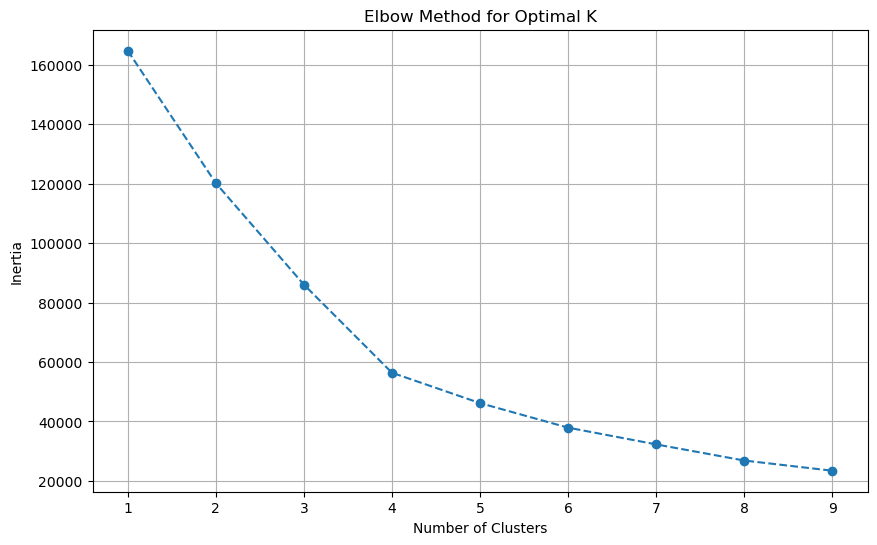

In [111]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [112]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_data)
clusters = kmeans.labels_

transformed_df['cluster'] = clusters

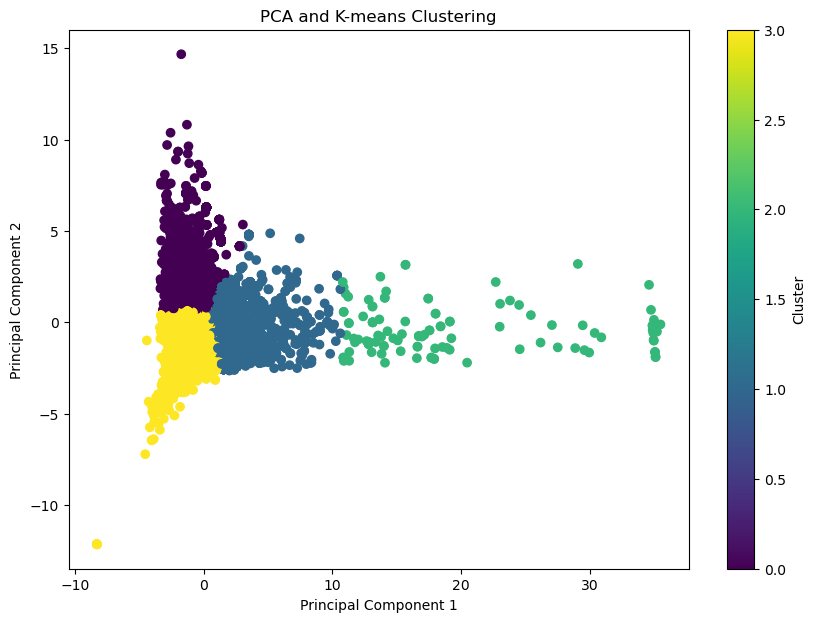

In [113]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA and K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [114]:
hosts_kmeans = hosts.copy()
hosts_kmeans['cluster'] = clusters

cluster_summary_mean = hosts_kmeans.groupby('cluster').mean()

print("Cluster Summary Statistics (Mean):")
cluster_summary_mean

Cluster Summary Statistics (Mean):


,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,price,vacancy_rate_365,accommodates,beds,...,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms
cluster,,,,,,,,,,,,,,,,,,,,,
0,2.490938e+08,-2072.003131,0.977622,0.918638,244.517341,353.914017,685.751426,0.658661,8.460742,5.135101,...,8.163536,4.815300,4.831250,4.796245,4.879248,4.878214,4.842081,4.746067,1.334325,2.653260
1,2.014850e+08,-2397.853015,0.922110,0.897810,121.687228,200.631736,258.255628,0.650230,4.554231,2.521060,...,5.307498,4.451943,4.513924,4.461649,4.606243,4.601512,4.678282,4.401802,1.011912,1.443365
2,2.886482e+08,-1795.189655,0.794783,0.810237,3.818966,8.353448,238.912918,0.402008,4.043103,2.171770,...,0.991379,2.482550,2.454400,2.683909,2.732371,2.758730,3.323241,2.536478,0.481037,1.458349
3,2.052674e+08,-2344.378957,0.968519,0.912033,18.086444,24.309867,220.407653,0.447746,3.906134,2.151286,...,12.365422,4.822325,4.848638,4.815505,4.886432,4.895138,4.845180,4.772223,1.665450,1.336905


In [115]:
cluster_summary_var = hosts_kmeans.groupby('cluster').var()

print("Cluster Summary Statistics (Variance):")
cluster_summary_var

Cluster Summary Statistics (Variance):


,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,price,vacancy_rate_365,accommodates,beds,...,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms
cluster,,,,,,,,,,,,,,,,,,,,,
0,3.486834e+16,1.438087e+06,0.008566,0.027223,447626.361058,1.058498e+06,511180.222974,0.051893,6.265522,3.770774,...,76.252831,0.016404,0.014317,0.020215,0.010444,0.010030,0.011483,0.019890,0.559046,0.910701
1,3.111751e+16,1.395394e+06,0.042547,0.047211,100649.148023,2.264918e+05,25791.505276,0.082339,2.458557,0.980722,...,44.459004,0.050429,0.052023,0.059592,0.050749,0.055716,0.043987,0.055190,0.488698,0.172886
2,3.063007e+16,1.119761e+06,0.112522,0.060418,98.201724,6.667870e+02,49687.336497,0.135990,5.318416,1.708119,...,2.996302,1.035305,0.993695,1.297143,1.537114,1.367291,1.472979,0.922962,0.617135,0.376627
3,2.920155e+16,1.270387e+06,0.013134,0.032930,3464.215865,7.086117e+03,23228.405170,0.088300,2.751079,0.974885,...,253.824115,0.014275,0.011243,0.017280,0.010022,0.007598,0.013991,0.017060,2.108640,0.181513


To Do: <br>PCA Elbow method to define number of components
<br>Get the (one-hot?) categoricals in the summary statistics (scaled data, sorted?)
<br>Describe the summary statistics in plain english
<BR>Use 
<br>sihohette score & dbscan (extra credit)